# CrossViT Validation
This notebook demonstrates how to extract features and reconstruct an image using a pretrained CrossViT model.

## 1. Load an example ImageNet-1k image
We download an arbitrary sample image from the ImageNet-1k dataset and display it.

Original image


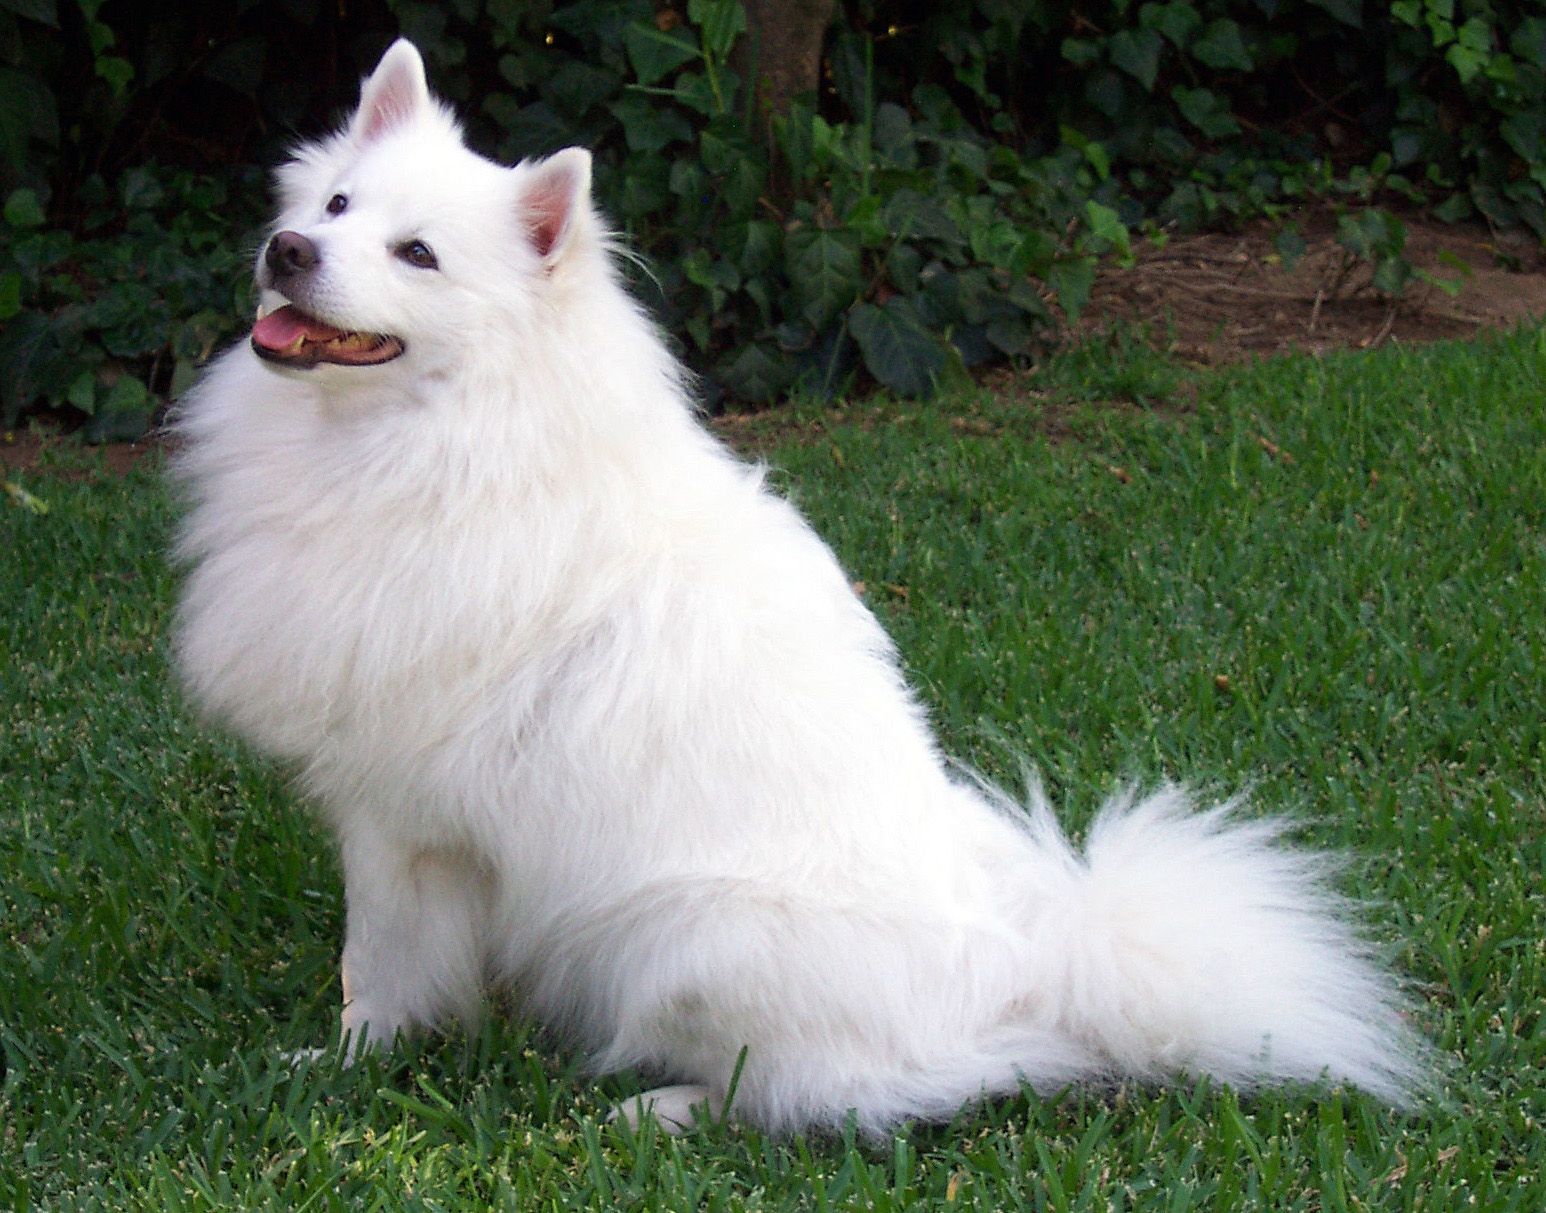

In [1]:
import requests
from PIL import Image
from IPython.display import display
from io import BytesIO
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
print("Original image")
display(image)


## 2. Extract hand-crafted descriptors
We resize the image to 224×224 and run the `FeatureExtractor` to obtain an edge map, a gray-level histogram and a colour-segmented image.

/home/vieunite/.cache/pypoetry/virtualenvs/visualsplit-tEI06kJP-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Edge map


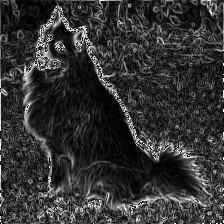

Gray-level histogram


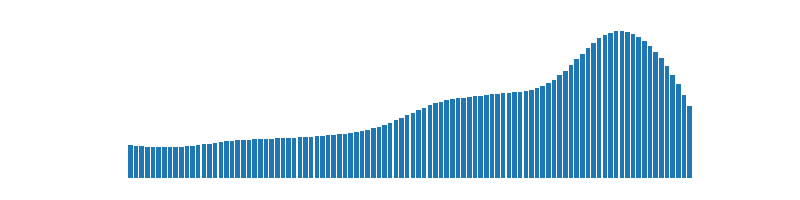

Segmented RGB


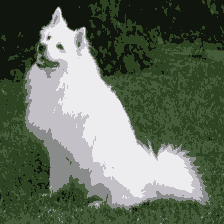

In [2]:
import torch
import torchvision.transforms as T
from visualsplit.utils import FeatureExtractor

transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
img_tensor = transform(image).unsqueeze(0)
extractor = FeatureExtractor()
edge, gray_hist, segmented_rgb, ab = extractor(img_tensor)

print("Edge map")
edge_img = Image.fromarray((edge.squeeze().numpy()*255).astype("uint8"))
display(edge_img)

print("Gray-level histogram")
fig = plt.figure(figsize=(8, 2))
plt.bar(range(gray_hist.shape[-1]), gray_hist.squeeze().numpy())
plt.axis("off")
buf = BytesIO()
fig.savefig(buf, format="png")
buf.seek(0)
plt.close(fig)
gl_hist = Image.open(buf)
display(gl_hist)

print("Segmented RGB")
seg_img = Image.fromarray((segmented_rgb.squeeze().permute(1, 2, 0).numpy()*255).astype("uint8"))
display(seg_img)

## 3. Load the CrossViT model
We download a pretrained checkpoint stored as `model.safetensors` and load it into the CrossViT network.

In [3]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_model
from visualsplit.models.CrossViT import CrossViTConfig, CrossViTForPreTraining
from visualsplit.config import Config
from pathlib import Path

weights_path = Config.DATA_CACHE_DIR / "model.safetensors"
if not weights_path.exists():
    hf_hub_download(
        repo_id="quchenyuan/Visual-Split-Model",
        filename="model.safetensors",
        local_dir=Config.DATA_CACHE_DIR,
        local_dir_use_symlinks=False,
    )
config = CrossViTConfig()
model = CrossViTForPreTraining(config)
missing, unexpected = load_model(model, str(weights_path))
model.eval()
missing, unexpected


/home/vieunite/.cache/pypoetry/virtualenvs/visualsplit-tEI06kJP-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


(set(), [])

## 4. Reconstruct the image
We feed the descriptors and the original tensor into the model to obtain a reconstruction.

Reconstruction


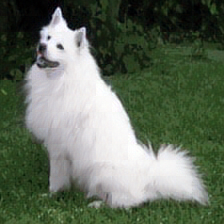

In [4]:
with torch.no_grad():
    outputs = model(edge, gray_hist, segmented_rgb, pixel_values=img_tensor)
    reconstruction = outputs["logits_reshape"].clamp(0, 1)

print("Reconstruction")
recon_img = Image.fromarray((reconstruction.squeeze().permute(1, 2, 0).numpy()*255).astype("uint8"))
display(recon_img)
